In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import pipeline
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [2]:
og_df = pd.read_csv('../data/emails_triagem.csv')

### Pre-processing

In [3]:
df = og_df[['Descrição', 'Tipo de registro do caso']].dropna().reset_index(drop=True).rename(columns={'Descrição': 'text',
                                                                                                      'Tipo de registro do caso': 'label'})

In [209]:
df['label'].value_counts()

label
Solicitação de Cotação                2562
Faturamento Incorreto                  443
Análise de Crédito                     175
Aditamento Contratual                  112
Medição Incorreta                       97
Precificação de Condição Comercial      51
Solicitação de Contrato                 40
Registro Incorreto                      36
Garantias                               16
Não Recebimento da Fatura               15
Conferência de tabela de preço           5
Name: count, dtype: int64

In [4]:
to_be_grouped = ['Precificação de Condição Comercial',
                 'Solicitação de Contrato',
                 'Registro Incorreto',
                 'Garantias',
                 'Não Recebimento da Fatura',
                 'Conferência de tabela de preço']
df['label'] = df['label'].replace(to_be_grouped, 'Outros')

In [5]:
df['label'].value_counts()

label
Solicitação de Cotação    2562
Faturamento Incorreto      443
Análise de Crédito         175
Outros                     163
Aditamento Contratual      112
Medição Incorreta           97
Name: count, dtype: int64

In [12]:
#removing values
id2label = {0: "Solicitação de Cotação",
            1: "Faturamento Incorreto",
            2: "Análise de Crédito",
            3: "Aditamento Contratual",
            4: "Medição Incorreta",
            5: "Outros"}

label2id = {"Solicitação de Cotação": 0,
            "Faturamento Incorreto": 1,
            "Análise de Crédito": 2,
            "Aditamento Contratual": 3,
            "Medição Incorreta": 4,
            "Outros": 5}

In [21]:
#df['label'] = df['label'].replace(label2id)

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [8]:
df_train['label'].value_counts()

label
Solicitação de Cotação    2049
Faturamento Incorreto      354
Análise de Crédito         140
Outros                     130
Aditamento Contratual       90
Medição Incorreta           78
Name: count, dtype: int64

In [9]:
df_test['label'].value_counts()

label
Solicitação de Cotação    513
Faturamento Incorreto      89
Análise de Crédito         35
Outros                     33
Aditamento Contratual      22
Medição Incorreta          19
Name: count, dtype: int64

In [106]:
classifier = pipeline("text-classification", model="../models/model_without_weights/model_grouped", max_length=512, truncation=True)

In [15]:
df_predictions = df_test[['text', 'label']]

In [17]:
df_predictions['label'].value_counts()

label
Solicitação de Cotação    513
Faturamento Incorreto      89
Análise de Crédito         35
Outros                     33
Aditamento Contratual      22
Medição Incorreta          19
Name: count, dtype: int64

In [18]:
def predict(row):
    email_text = row['text']
    pred = classifier(email_text)
    pred_label = pred[0]['label']
    score = pred[0]['score']
    return pred_label, score


In [20]:
labels = []
scores = []

for i in tqdm(df_predictions.index):
    label, score = predict(df_predictions.loc[i])
    labels.append(label)
    scores.append(score)

df_predictions['pred_label'] = labels
df_predictions['score'] = scores

100%|██████████| 711/711 [05:23<00:00,  2.20it/s]


In [87]:
df_predictions

,text,label,pred_label,score
3034,"Prezados, Encaminhamos o Termo de Referência p...",Solicitação de Cotação,Solicitação de Cotação,0.996493
2461,"Prezados, boa tarde, O Grupo econômico RIO ATL...",Solicitação de Cotação,Solicitação de Cotação,0.995592
121,[https://cdn.engiesolucoes.digital/img/cabecal...,Faturamento Incorreto,Faturamento Incorreto,0.637685
2484,"Prezados, Encaminhamos o Termo de Referência p...",Solicitação de Cotação,Solicitação de Cotação,0.996500
2928,"Prezados, bom dia Gostaríamos de convidá-los p...",Solicitação de Cotação,Solicitação de Cotação,0.993810
...,...,...,...,...
725,"Prezados, Convidamos a sua empresa a participa...",Solicitação de Cotação,Solicitação de Cotação,0.995238
1560,"Prezados, Encaminhamos o Termo de Referência p...",Solicitação de Cotação,Solicitação de Cotação,0.996497
2116,Bom dia. Solicito alterar contato para envio d...,Faturamento Incorreto,Faturamento Incorreto,0.964665
1783,"Prezados, Convidamos a sua empresa a participa...",Solicitação de Cotação,Solicitação de Cotação,0.995412


In [88]:
df_predictions['pred_label'].value_counts()

pred_label
Solicitação de Cotação    523
Faturamento Incorreto      93
Análise de Crédito         33
Outros                     23
Medição Incorreta          21
Aditamento Contratual      18
Name: count, dtype: int64

### Confusion Matrix and Report

In [24]:
true_labels = df_predictions['label']
predicted_labels = df_predictions['pred_label']

print(classification_report(true_labels, predicted_labels))

                        precision    recall  f1-score   support

 Aditamento Contratual       0.94      0.77      0.85        22
    Análise de Crédito       0.97      0.91      0.94        35
 Faturamento Incorreto       0.87      0.91      0.89        89
     Medição Incorreta       0.57      0.63      0.60        19
                Outros       0.78      0.55      0.64        33
Solicitação de Cotação       0.98      0.99      0.98       513

              accuracy                           0.94       711
             macro avg       0.85      0.79      0.82       711
          weighted avg       0.94      0.94      0.94       711



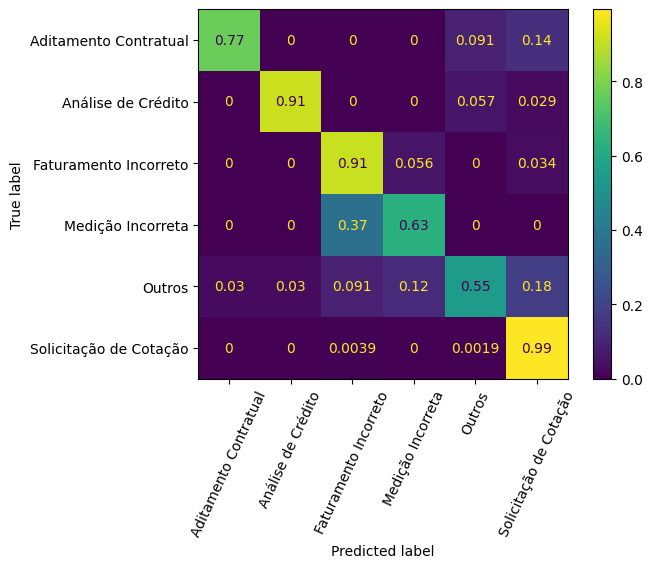

In [114]:
ConfusionMatrixDisplay.from_predictions(y_true=true_labels, y_pred=predicted_labels, normalize='true', xticks_rotation=65)

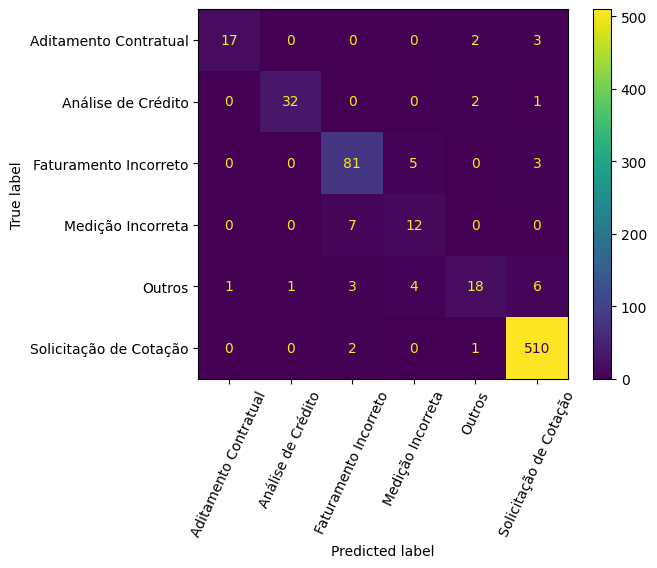

In [115]:
ConfusionMatrixDisplay.from_predictions(y_true=true_labels, y_pred=predicted_labels, xticks_rotation=65)#, normalize='true')

In [221]:
true_labels_90 = df_predictions[df_predictions.score > .90]['label']
pred_labels_90 = df_predictions[df_predictions.score > .90]['pred_label']

print(classification_report(true_labels_90, pred_labels_90))

                        precision    recall  f1-score   support

 Aditamento Contratual       1.00      0.50      0.67         2
    Análise de Crédito       1.00      0.97      0.98        32
 Faturamento Incorreto       0.97      0.98      0.97        57
     Medição Incorreta       0.00      0.00      0.00         1
                Outros       0.00      0.00      0.00         4
Solicitação de Cotação       0.99      1.00      0.99       506

              accuracy                           0.99       602
             macro avg       0.66      0.57      0.60       602
          weighted avg       0.98      0.99      0.98       602



/home/victor.viola/pocs/copel-generative-ai/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor.viola/pocs/copel-generative-ai/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor.viola/pocs/copel-generative-ai/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

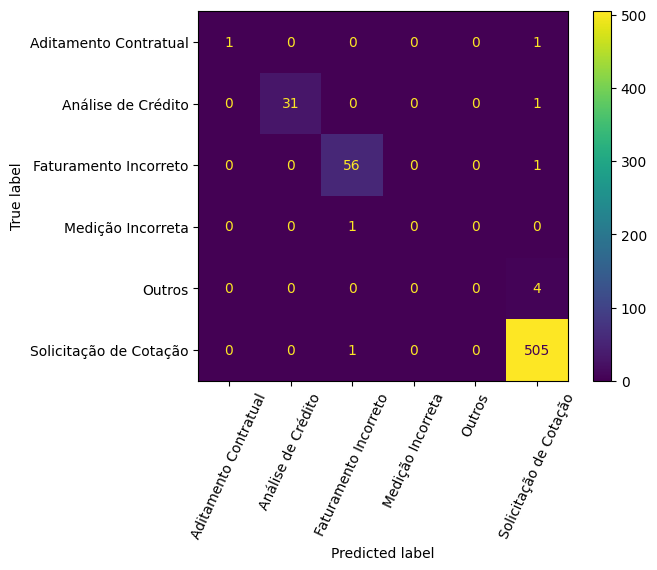

In [222]:
ConfusionMatrixDisplay.from_predictions(y_true=true_labels_90, y_pred=pred_labels_90, xticks_rotation=65)#, normalize='true')

### ROC curves

In [124]:
df_predictions_all = df_test[['text', 'label']]

In [108]:
classifier_all_scores = pipeline("text-classification", 
                                 model="../models/model_without_weights/model_grouped", 
                                 max_length=512, 
                                 truncation=True,
                                 return_all_scores=True)

In [117]:
pred = classifier_all_scores(df_predictions['text'][121])

In [123]:
pred[0]

[{'label': 'Solicitação de Cotação', 'score': 0.00265903165563941},
 {'label': 'Faturamento Incorreto', 'score': 0.6376848816871643},
 {'label': 'Análise de Crédito', 'score': 0.011334349401295185},
 {'label': 'Aditamento Contratual', 'score': 0.005097521934658289},
 {'label': 'Medição Incorreta', 'score': 0.30561012029647827},
 {'label': 'Outros', 'score': 0.03761408478021622}]

In [122]:
def predict_allscores(row):
    email_text = row['text']
    pred = classifier(email_text)
    pred_label = pred[0]['label']
    pred_all = classifier_all_scores(email_text)
    score_0 = pred_all[0][0]['score']
    score_1 = pred_all[0][1]['score']
    score_2 = pred_all[0][2]['score']
    score_3 = pred_all[0][3]['score']
    score_4 = pred_all[0][4]['score']
    score_5 = pred_all[0][5]['score']
    return pred_label, score_0, score_1, score_2, score_3, score_4, score_5

In [125]:
labels = []
scores_0 = []
scores_1 = []
scores_2 = []
scores_3 = []
scores_4 = []
scores_5 = []

for i in tqdm(df_predictions_all.index):
    label, score_0, score_1, score_2, score_3, score_4, score_5 = predict_allscores(df_predictions.loc[i])
    labels.append(label)
    scores_0.append(score_0)
    scores_1.append(score_1)
    scores_2.append(score_2)
    scores_3.append(score_3)
    scores_4.append(score_4)
    scores_5.append(score_5)

df_predictions_all['pred_label'] = labels
df_predictions_all['score_Solicitação de Cotação'] = scores_0
df_predictions_all['score_Faturamento Incorreto'] = scores_1
df_predictions_all['score_Análise de Crédito'] = scores_2
df_predictions_all['score_Aditamento Contratual'] = scores_3
df_predictions_all['score_Medição Incorreta'] = scores_4
df_predictions_all['score_Outros'] = scores_5

100%|██████████| 711/711 [10:01<00:00,  1.18it/s]


In [129]:
true_labels = df_predictions_all['label']
predicted_labels = df_predictions_all['pred_label']

In [150]:
df_predictions_all

,text,label,pred_label,score_Solicitação de Cotação,score_Faturamento Incorreto,score_Análise de Crédito,score_Aditamento Contratual,score_Medição Incorreta,score_Outros
3034,"Prezados, Encaminhamos o Termo de Referência p...",Solicitação de Cotação,Solicitação de Cotação,0.996493,0.000732,0.000845,0.000584,0.000568,0.000779
2461,"Prezados, boa tarde, O Grupo econômico RIO ATL...",Solicitação de Cotação,Solicitação de Cotação,0.995592,0.000596,0.001038,0.000894,0.000667,0.001212
121,[https://cdn.engiesolucoes.digital/img/cabecal...,Faturamento Incorreto,Faturamento Incorreto,0.002659,0.637685,0.011334,0.005098,0.305610,0.037614
2484,"Prezados, Encaminhamos o Termo de Referência p...",Solicitação de Cotação,Solicitação de Cotação,0.996500,0.000728,0.000838,0.000585,0.000568,0.000781
2928,"Prezados, bom dia Gostaríamos de convidá-los p...",Solicitação de Cotação,Solicitação de Cotação,0.993810,0.000603,0.002501,0.000831,0.000593,0.001662
...,...,...,...,...,...,...,...,...,...
725,"Prezados, Convidamos a sua empresa a participa...",Solicitação de Cotação,Solicitação de Cotação,0.995238,0.001500,0.000411,0.000741,0.000793,0.001317
1560,"Prezados, Encaminhamos o Termo de Referência p...",Solicitação de Cotação,Solicitação de Cotação,0.996497,0.000729,0.000838,0.000590,0.000568,0.000778
2116,Bom dia. Solicito alterar contato para envio d...,Faturamento Incorreto,Faturamento Incorreto,0.003137,0.964665,0.002606,0.002771,0.021604,0.005217
1783,"Prezados, Convidamos a sua empresa a participa...",Solicitação de Cotação,Solicitação de Cotação,0.995412,0.001436,0.000383,0.000848,0.000714,0.001206


In [154]:
label_binarizer = LabelBinarizer().fit(df_train['label'])
y_onehot_test = label_binarizer.transform(df_test['label'])
y_onehot_test.shape  # (n_samples, n_classes)

(711, 6)

In [155]:
label_binarizer.classes_

array(['Aditamento Contratual', 'Análise de Crédito',
       'Faturamento Incorreto', 'Medição Incorreta', 'Outros',
       'Solicitação de Cotação'], dtype='<U22')

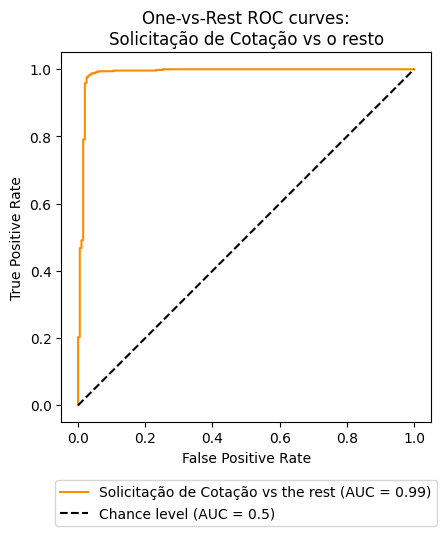

In [156]:
class_of_interest = "Solicitação de Cotação"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    df_predictions_all[f'score_{class_of_interest}'],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs o resto")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()


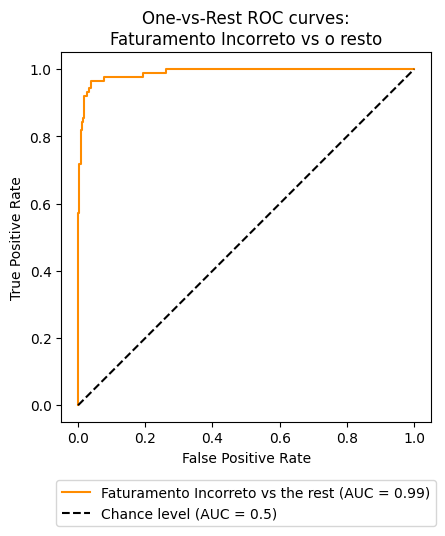

In [157]:
class_of_interest = "Faturamento Incorreto"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    df_predictions_all[f'score_{class_of_interest}'],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs o resto")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()


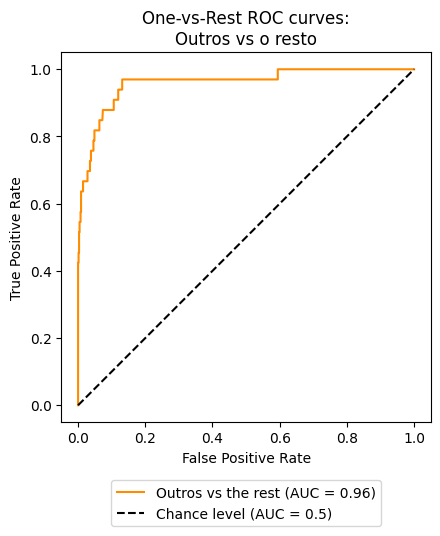

In [158]:
class_of_interest = "Outros"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    df_predictions_all[f'score_{class_of_interest}'],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs o resto")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()


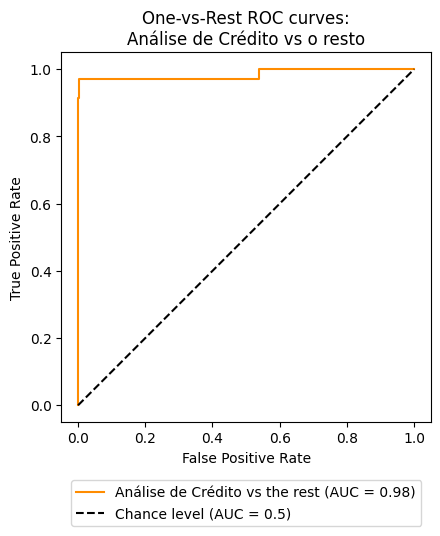

In [159]:
class_of_interest = "Análise de Crédito"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    df_predictions_all[f'score_{class_of_interest}'],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs o resto")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()


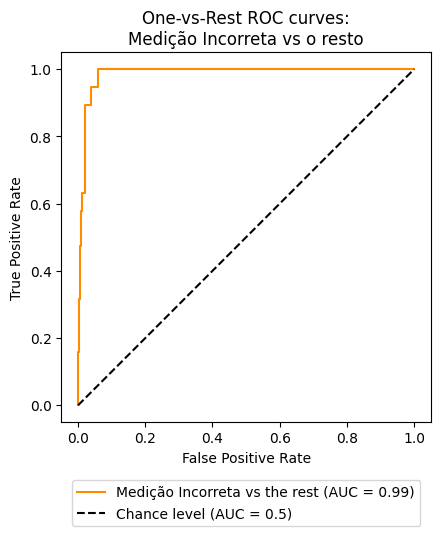

In [160]:
class_of_interest = "Medição Incorreta"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    df_predictions_all[f'score_{class_of_interest}'],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs o resto")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()


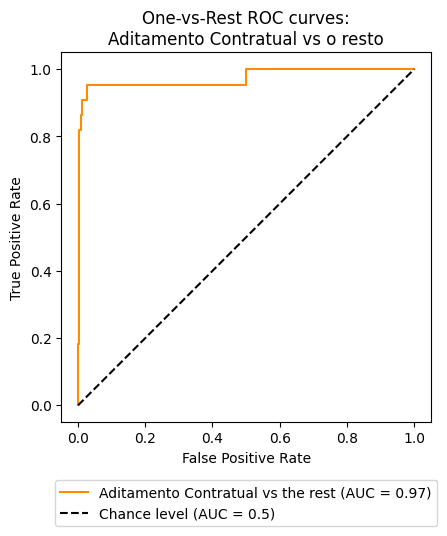

In [161]:
class_of_interest = "Aditamento Contratual"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    df_predictions_all[f'score_{class_of_interest}'],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs o resto")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()


In [194]:
y_score = []

for i in range(len(df_predictions_all)):
    score = []
    for y in range(3, 9):
        score.append(df_predictions_all.iloc[i, y])
    y_score.append(score)

y_score = np.array(y_score)

In [ ]:
n_classes = len(np.unique(y))

In [206]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.51
Macro-averaged One-vs-Rest ROC AUC score:
0.60


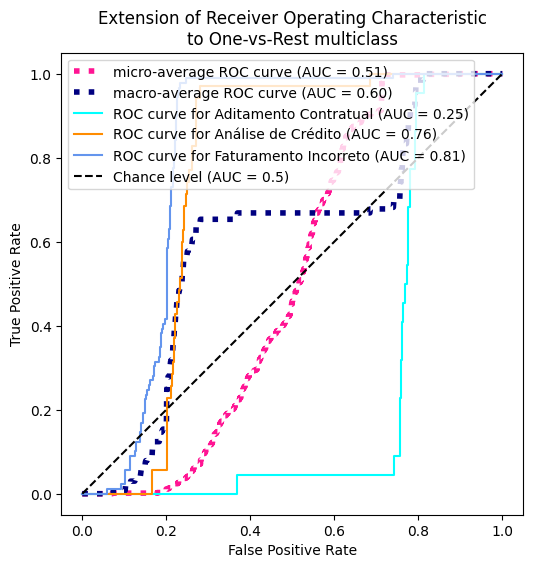

In [207]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {label_binarizer.classes_[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()


### Predict new e-mails

In [51]:
df = pd.read_csv('../data/emails_sem_rotulo.csv', sep=';').rename(columns={"Descrição": "text"})[["Número do caso", "Email da Web", "text"]]
df.dropna(subset=['text'], inplace=True)
df.reset_index(inplace=True)
df = df.drop(columns='index')
df["Número do caso"] = df["Número do caso"].astype(str).map(lambda x: x.split(".")[0])

In [52]:
df

,Número do caso,Email da Web,text
0,21367,mesa@enermerco.com.br,"Prezados(as), bom dia! Gostaríamos de solicita..."
1,21371,mauricio.oliveira@enerbrax.com,Prezados. Favor abaixo os dados para faturamen...
2,21381,atila.dias@se.com,"[image013] Prezados, Poderiam, por gentileza, ..."
3,21392,smart@app.engie.com,[https://cdn.engiesolucoes.digital/img/cabecal...
4,21398,rfq@esferaenergia.com.br,"Prezados, bom dia! A Esfera Energia convida pa..."
...,...,...,...
883,24099,gestao@reenergisa.com.br,"Prezados, bom dia, A Energisa Comercializadora..."
884,24101,luana.costa@mercattoenergia.com.br,"Prezados, bom dia! A empresa TECNOHARD, repres..."
885,24102,ana@electricservice.com.br,Bom dia! A CORSAN - COMPANHIA RIOGRANDENSE DE ...
886,24104,luana.costa@mercattoenergia.com.br,"Prezados, bom dia! A empresa Arrozella, repres..."


In [53]:
classifier = pipeline("text-classification", model="../models/model_without_weights/model_grouped", max_length=512, truncation=True)

In [54]:
def predict(row):
    email_text = row['text']
    pred = classifier(email_text)
    pred_label = pred[0]['label']
    score = pred[0]['score']
    return pred_label, score

In [56]:
labels = []
scores = []

for i in tqdm(df.index):
    label, score = predict(df.loc[i])
    labels.append(label)
    scores.append(score)

df['pred_label'] = labels
df['score'] = scores

100%|██████████| 888/888 [06:52<00:00,  2.15it/s]


In [58]:
df

,Número do caso,Email da Web,text,pred_label,score
0,21367,mesa@enermerco.com.br,"Prezados(as), bom dia! Gostaríamos de solicita...",Solicitação de Cotação,0.992241
1,21371,mauricio.oliveira@enerbrax.com,Prezados. Favor abaixo os dados para faturamen...,Faturamento Incorreto,0.949117
2,21381,atila.dias@se.com,"[image013] Prezados, Poderiam, por gentileza, ...",Solicitação de Cotação,0.986246
3,21392,smart@app.engie.com,[https://cdn.engiesolucoes.digital/img/cabecal...,Faturamento Incorreto,0.621135
4,21398,rfq@esferaenergia.com.br,"Prezados, bom dia! A Esfera Energia convida pa...",Solicitação de Cotação,0.946478
...,...,...,...,...,...
883,24099,gestao@reenergisa.com.br,"Prezados, bom dia, A Energisa Comercializadora...",Solicitação de Cotação,0.991731
884,24101,luana.costa@mercattoenergia.com.br,"Prezados, bom dia! A empresa TECNOHARD, repres...",Solicitação de Cotação,0.993626
885,24102,ana@electricservice.com.br,Bom dia! A CORSAN - COMPANHIA RIOGRANDENSE DE ...,Solicitação de Cotação,0.994686
886,24104,luana.costa@mercattoenergia.com.br,"Prezados, bom dia! A empresa Arrozella, repres...",Solicitação de Cotação,0.993423


In [59]:
df.to_csv("../data/emails_sem_rotulo_predicted.csv")